In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

In [2]:
from sklearn import set_config
set_config(display="diagram")
set_config(transform_output="pandas")

In [3]:
mush = pd.read_csv('https://drive.google.com/uc?export=download&id=1eT8uTctwIx9yu2m207ZD1zSfshT9B24k')

In [4]:
mush

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,Id,poisonous
0,k,e,False,w,w,v,6573,1
1,f,e,True,p,w,y,4426,0
2,b,w,False,w,w,s,7018,0
3,k,g,False,w,w,n,5789,0
4,f,n,True,p,g,v,6187,0
...,...,...,...,...,...,...,...,...
6494,f,g,False,b,b,v,7002,1
6495,k,e,False,p,p,v,7323,1
6496,f,g,False,n,b,y,6206,1
6497,f,n,True,w,w,s,4658,0


In [5]:
mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               6499 non-null   object
 1   cap.color               6499 non-null   object
 2   bruises                 6499 non-null   bool  
 3   stalk.color.above.ring  6499 non-null   object
 4   stalk.color.below.ring  6499 non-null   object
 5   population              6499 non-null   object
 6   Id                      6499 non-null   int64 
 7   poisonous               6499 non-null   int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 361.9+ KB


In [6]:
mush.nunique()

cap.shape                    6
cap.color                   10
bruises                      2
stalk.color.above.ring       9
stalk.color.below.ring       9
population                   6
Id                        6499
poisonous                    2
dtype: int64

In [7]:
X = mush.drop('Id', axis=1).copy()
y = X.pop('poisonous')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [9]:
from numpy import arange

In [10]:
preprocessor = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)

In [11]:
mush_pipe = make_pipeline(preprocessor,                  
    RandomForestClassifier(class_weight={0: 1, 1: 10})
).set_output(transform='pandas')
param_grid = {
    "randomforestclassifier__n_estimators": [200 ,500],
    "randomforestclassifier__max_depth": range(5, 15, 5),
    "randomforestclassifier__min_samples_leaf": range(5, 15, 5),
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__ccp_alpha": arange(0, 0.1)
}

In [12]:
search = GridSearchCV(
    mush_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

In [13]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                      sparse_output=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight={0: 1,
                                                                             1: 10}))]),
             param_grid={'randomforestclassifier__ccp_alpha': array([0.]),
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': range(5, 15, 5),
                         'randomforestclassifier__min_samples_leaf': range(5, 15, 5),
                         'randomforestclassifier__n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [14]:
search.best_params_

{'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 500}

In [15]:
my_mush = search.best_estimator_

In [16]:
y_mush_predict = my_mush.predict(X_test)

In [17]:
accuracy_score(
    y_true=y_test,
    y_pred=y_mush_predict
)

0.9307692307692308

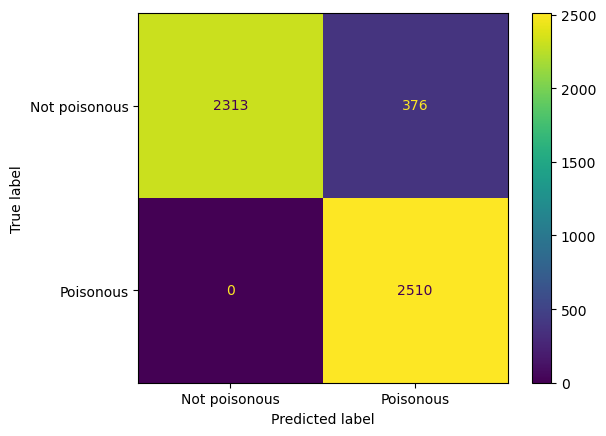

In [18]:
ConfusionMatrixDisplay.from_estimator(my_mush, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

In [19]:
from sklearn.metrics import recall_score

recall_score(y_true=y_test, y_pred=y_mush_predict)

1.0

In [20]:
roc_curve(y_true=y_test, y_score=y_mush_predict)

(array([0.        , 0.13782542, 1.        ]),
 array([0., 1., 1.]),
 array([inf,  1.,  0.]))

In [21]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_mush_predict)
roc_auc = auc(fpr, tpr)

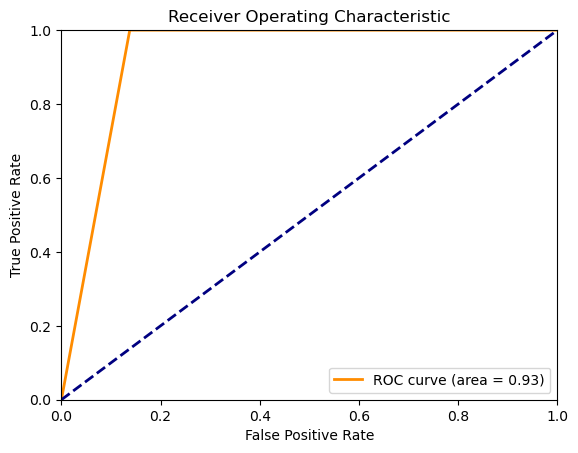

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
auc_score = roc_auc_score(y_test, y_mush_predict)
print(f'Best AUC: {auc_score}')

Best AUC: 0.9310872894333844


In [24]:
new_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1eWxV9FGj6D-YnMsv4mHMWRcGIKbjrXYL')

In [25]:
new_data

,Id,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population
0,5165,f,w,w,w,True,v
1,4281,f,g,n,p,False,v
2,231,x,n,w,p,True,v
3,3890,f,n,w,w,False,s
4,1521,x,y,n,p,False,v
...,...,...,...,...,...,...,...
1620,983,x,n,w,y,False,v
1621,7055,x,e,p,g,True,v
1622,7456,x,y,b,n,False,y
1623,5132,x,w,w,w,True,n


In [26]:
id_col = new_data.pop('Id')

In [27]:
order_of_columns = X.columns.to_list()
new_data = new_data[order_of_columns]

In [28]:
poisonous_pred = my_mush.predict(new_data)

In [29]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'poisonous':poisonous_pred
})

In [30]:
submission_file.head()

,Id,poisonous
0,5165,1
1,4281,1
2,231,0
3,3890,0
4,1521,1


In [31]:
submission_file.to_csv('submission_1.csv', index=False)

## Trying another preprocessor with more parameters

In [32]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False), X.columns)
    ],
    remainder='passthrough'
)

In [33]:
mush_pipe_2 = make_pipeline(preprocessor_2,
    RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
).set_output(transform='pandas')
param_grid_2 = {
    "randomforestclassifier__n_estimators": [200 ,500],
    "randomforestclassifier__max_depth": [15],
    "randomforestclassifier__max_features": ['sqrt', 'log2', None],
    "randomforestclassifier__min_samples_leaf": [5, 10],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__oob_score": [True],
    "randomforestclassifier__min_impurity_decrease": [0.0],
    "randomforestclassifier__ccp_alpha": [0.0]
}

In [34]:
search_2 = GridSearchCV(
    mush_pipe_2,
    param_grid=param_grid_2,
    cv=5,
    scoring='accuracy',
    verbose=1
)

In [35]:
search_2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       sparse_output=False),
                                                                         Index(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object'))])),
                                       ('randomforestclassifier'...
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [15],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  None],
                         'randomforestclassifier__min_impurity_decrease': [0.0],
                         'randomforestclassifier__min_samples_leaf': [5, 10],
                         'randomforestclassifier__n_estimators': [200, 500],
                         'randomforestclassifier__oob_score': [True]},
             scoring='accuracy', verbose=1)

In [36]:
search_2.best_params_

{'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 500,
 'randomforestclassifier__oob_score': True}

In [50]:
my_mush_2a = search_2.best_estimator_

In [51]:
y_mush_predict_2a = my_mush_2a.predict(X_test)

In [52]:
accuracy_score(
    y_true=y_test,
    y_pred=y_mush_predict_2a
)

0.9415384615384615

In [40]:
from sklearn.metrics import recall_score

recall_score(y_true=y_test, y_pred=y_mush_predict_2a)

1.0

In [53]:
poisonous_pred_2a = my_mush_2a.predict(new_data)

In [54]:
submission_file_final = pd.DataFrame({
    'Id':id_col,
    'poisonous':poisonous_pred_2a
})

In [55]:
submission_file_final.head()

,Id,poisonous
0,5165,1
1,4281,1
2,231,0
3,3890,0
4,1521,1


In [48]:
submission_file_final.to_csv('submission_final.csv', index=False)

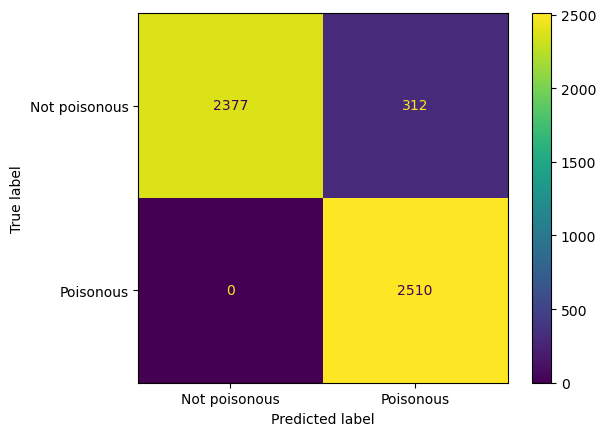

In [56]:
ConfusionMatrixDisplay.from_estimator(my_mush_2a, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

In [58]:
from sklearn.metrics import recall_score

recall_score(y_true=y_test, y_pred=y_mush_predict_2a)

1.0

In [263]:
poisonous_pred_2 = my_mush_2a.predict(new_data)

In [264]:
submission_file_2 = pd.DataFrame({
    'Id':id_col,
    'poisonous':poisonous_pred_2
})

In [265]:
submission_file_2.to_csv('submission_2a2.csv', index=False)